## Imports

In [40]:
# Add parent directory to path for local imports
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
from torch.utils.data import Dataset, DataLoader, sampler
from collections import defaultdict
from textwrap import wrap
%matplotlib inline

In [2]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [3]:
transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class ImageFolderWithPaths(dset.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

train_dataset = ImageFolderWithPaths('../Dataset/train', transform=transform)
val_dataset = ImageFolderWithPaths('../Dataset/val', transform=transform)
test_dataset = ImageFolderWithPaths('../Dataset/test', transform=transform)

In [4]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
FOOD_LIST_PATH = '../VireoFood172/SplitAndIngreLabel/FoodList.txt'
food_names = [] # List of length 172 where index is the food label, and value is the food name.
with open(FOOD_LIST_PATH) as fp:
    food_names = fp.read().splitlines()

classes = train_dataset.classes
num_classes = len(classes)
print(num_classes)

172


In [7]:
def model_label_to_class_label(model_label):
    return int(classes[model_label])

def class_label_to_model_label(class_label):
    return classes.index(str(class_label))

def model_label_to_class_name(model_label):
    class_label = model_label_to_class_label(model_label)
    return class_label_to_class_name(class_label)

def class_label_to_class_name(class_label):
    return food_names[class_label - 1]

In [8]:
print(model_label_to_class_label(1))
print(class_label_to_model_label(10))

print(model_label_to_class_name(1))
print(class_label_to_class_name(10))

10
1
Fried Sweet and Sour Tenderloin
Fried Sweet and Sour Tenderloin


## Evaluation

In [9]:
# Load the model.
PATH = "../saved_models/food/res18/res18-unfreeze.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model
history = torch.load('../saved_models/food/res18/res18-unfreeze-history.pt')
LOSS, ACC, LOSS_V, ACC_V = (history['loss'], history['acc'], history['loss_v'], history['acc_v'])

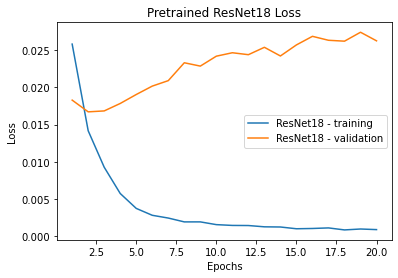

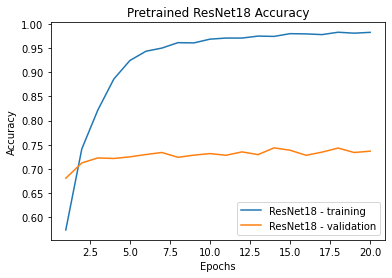

In [10]:
# Loss and Accuracy Curves
from utils.plots import plot_loss_and_accuracy_curves
plot_loss_and_accuracy_curves('ResNet18', LOSS, ACC, LOSS_V, ACC_V)

In [11]:
# Evaluation: Top-1 Accuracy

def compute_top_1_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels, paths = data
            images = gpu(images)
            labels = gpu(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Top 1 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))

compute_top_1_accuracy(model)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Top 1 Accuracy of the network on the all test images: 73.75 %


In [13]:
# Evaluation: Top-5 Accuracy

def compute_top_5_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels, paths = data
            images = gpu(images)
            labels = gpu(labels)
            outputs = model(images)
            _, predicted = torch.topk(outputs.data, 5, dim=1)
            total += labels.size(0)
            for i in range(predicted.shape[0]):
                top_5_predictions = predicted[i]
                label = labels[i]
                if label in top_5_predictions:
                    correct += 1
    print('Top 5 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))
    
compute_top_5_accuracy(model)

Top 5 Accuracy of the network on the all test images: 91.74 %


## Visualizing Common Failure Cases

In [14]:
import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [15]:
# Store y_pred and y_test on the test set for evaluation.

y_pred = []
y_test = []
all_paths = []
with torch.no_grad():
    model.eval()
    for data in test_dataloader:
        images, labels, paths = data
        images = gpu(images)
        labels = gpu(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_test.extend(labels.cpu().numpy().tolist())
        all_paths.extend(paths)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Create ```misclassification_paths```, a dictionary that maps from a food category label (between 0 - 171) to an inner dictionary holding misclassified images. The inner dictionary maps from the incorrectly predicted food category label to a list of image paths that were predicted as that category.

In [16]:
misclassification_paths = dict()
class_to_paths = defaultdict(list)
for i in range(num_classes):
    misclassification_paths[i] = defaultdict(list)

for pred, label, path in zip(y_pred, y_test, all_paths):
    class_to_paths[label].append(path)
    if label != pred:
        misclassification_paths[label][pred].append(path)

Create ```top_misclassifications```, a dictionary that maps from a food category label (between 0 and 171) to an inner dictionary containing data about the most commonly confused class for that category. 

In [50]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(cnf_matrix)
print(cnf_matrix[0][0], sum(cnf_matrix[0]))

top_misclassifications = dict()
for i in range(len(cnf_matrix)):
    most_confused_class = -1
    num_mistakes = -1
    for j in range(len(cnf_matrix)):
        if j == i:
            continue
        if cnf_matrix[i][j] > num_mistakes:
            num_mistakes = cnf_matrix[i][j]
            most_confused_class = j
    data = dict()
    data["num_mistakes"] = num_mistakes
    data["most_confused_class"] = most_confused_class
    data["paths"] = misclassification_paths[i][most_confused_class]
    top_misclassifications[i] = data

Confusion Matrix

[[205   8   0 ...   0   2   0]
 [  1 235   0 ...   0   0   0]
 [  0   0  55 ...   0   0   0]
 ...
 [  0   0   0 ...  86   0   0]
 [  0   0   0 ...   3  64   0]
 [  0   0   0 ...   0   0 152]]
205 307


For each class, print the top misclassified food category. Store these results in ```top_misclassifications```, a dictionary that maps from a food category label (between 0 and 171) to a list of paths of images of that category that were incorrectly classified as the top misclassified category.

In [61]:
dash = '-' * 110
print(dash)
print('{:<50s}{:^60s}{:^5s}'.format("Correct Food", "Top Misclassified Food", "Num Mistakes"))
print(dash)
for label in top_misclassifications:
    most_confused_class = top_misclassifications[label]['most_confused_class']
    num_mistakes = top_misclassifications[label]['num_mistakes']
    
    correct_class_label = model_label_to_class_label(label)
    misclassified_class_label = model_label_to_class_label(most_confused_class)
    correct_class_name = class_label_to_class_name(correct_class_label) + " ({},{})".format(label, int(correct_class_label))
    misclassified_class_name = class_label_to_class_name(misclassified_class_label) + " ({},{})".format(most_confused_class, misclassified_class_label)
    print('{:<50s}{:^50s}{:^5d}'.format(correct_class_name,  misclassified_class_name, num_mistakes)) 
    #print(correct_class_name + " | " + misclassified_class_name + str(num_mistakes))

--------------------------------------------------------------------------------------------------------------
Correct Food                                                         Top Misclassified Food                   Num Mistakes
--------------------------------------------------------------------------------------------------------------
Braised Pork (0,1)                                             Braised pork leg (34,13)              12  
Fried Sweet and Sour Tenderloin (1,10)                  Cripsy sweet & sour pork slices (95,3)       12  
Fried egg (2,100)                                       Fried Baked Scallion Pancake (55,149)        10  
Noodles with Wonton (3,101)                       Boiled Fish with Pickled Cabbage and Chili (103,37)  2  
Hot and Sour Fern Root Noodles (4,102)                    Hot and Sour Rice Noodles (48,142)          9  
Sour cabbage (5,103)                                          Shredded cabbage (141,71)              16  
Braised Intestines

## 5x5 Misclassification Plots

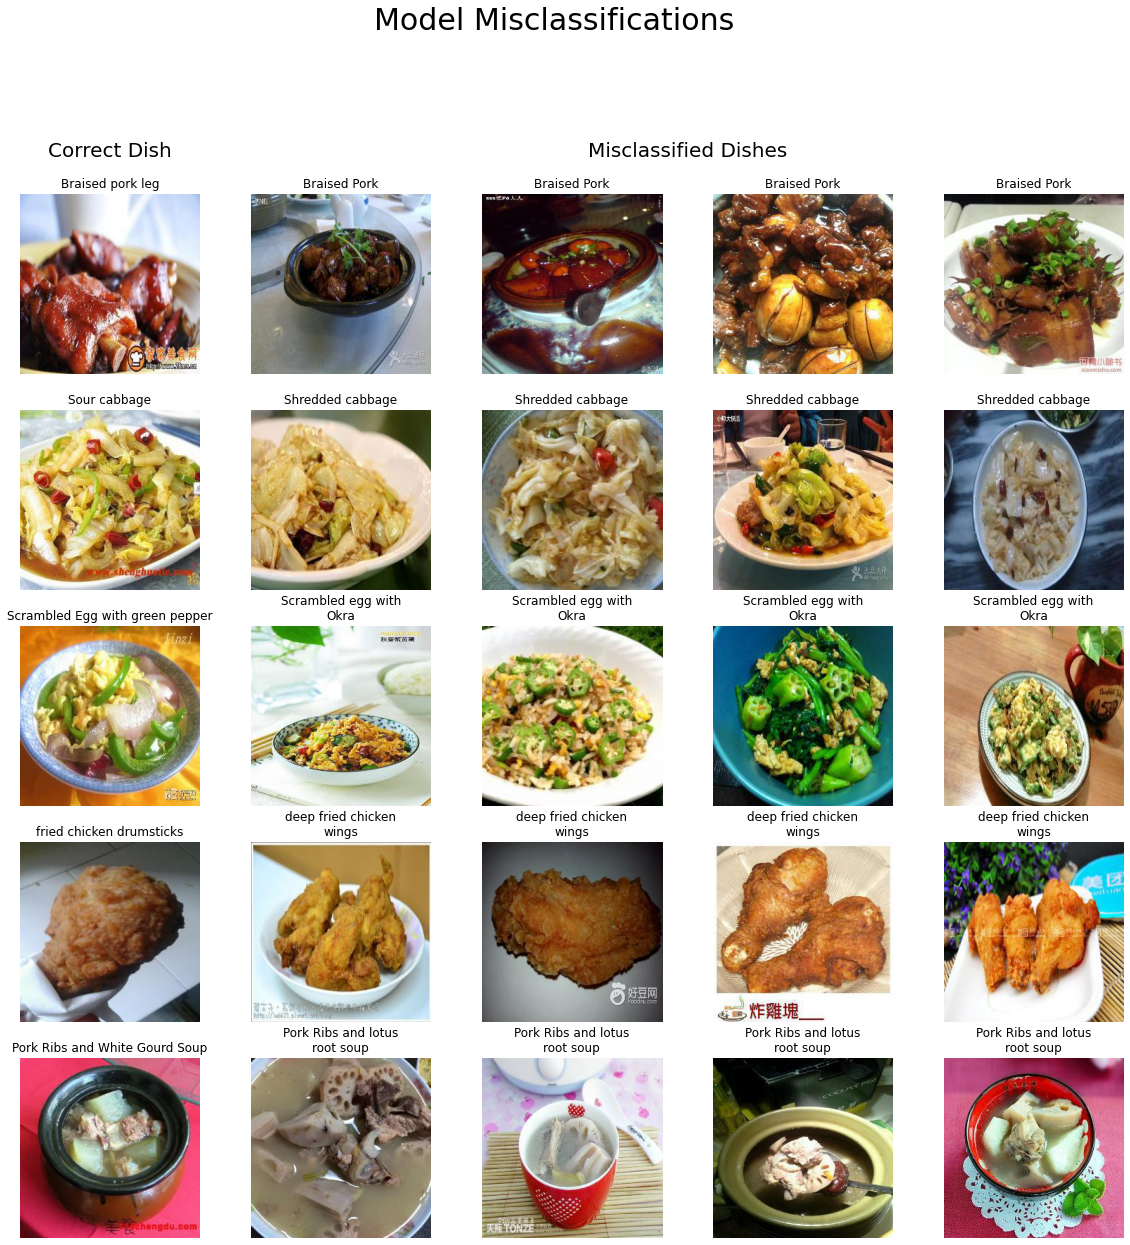

In [77]:
food_candidates = ["Braised Pork", "Shredded cabbage", "Scrambled egg with Okra", "deep fried chicken wings", "Pork Ribs and lotus root soup"]

num_rows = 5
num_cols = 5
line_length = 20
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,20)) 
fig.suptitle("Model Misclassifications", fontsize=30)
# adjust the subplots, i.e. leave more space at the top to accomodate the additional titles
fig.subplots_adjust(top=0.85) 

for i, food in enumerate(food_candidates):
    class_label = food_names.index(food) + 1
    model_label = class_label_to_model_label(class_label)
    misclassified_paths = top_misclassifications[model_label]["paths"]
    pred_image_path = class_to_paths[top_misclassifications[model_label]["most_confused_class"]][0]
    title = model_label_to_class_name(top_misclassifications[model_label]["most_confused_class"])
    axes[i][0].set_title(title)
    axes[i][0].imshow(Image.open(pred_image_path))
    axes[i][0].axis('off')
    for j, path in enumerate(misclassified_paths[0:num_cols - 1]):
        title = "\n".join(wrap(food, line_length))
        axes[i][j + 1].set_title(title)
        axes[i][j + 1].imshow(Image.open(path))
        axes[i][j + 1].axis('off')
    ext.append([axes[0,i].get_window_extent().x0, axes[0,i].get_window_extent().width ])
        
# this is optional
# from the axes bounding boxes calculate the optimal position of the column spanning title
inv = fig.transFigure.inverted()
width_left = ext[0][0]+(ext[0][0]+ext[0][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )
width_right = ext[1][0]+(ext[4][0]+ext[4][1]-ext[1][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0],0.88,"Correct Dish", va="center", ha="center", size=20)
plt.figtext(right_center[0],0.88,"Misclassified Dishes", va="center", ha="center", size=20)

# plt.show()
plt.savefig('food_failure_cases.png')

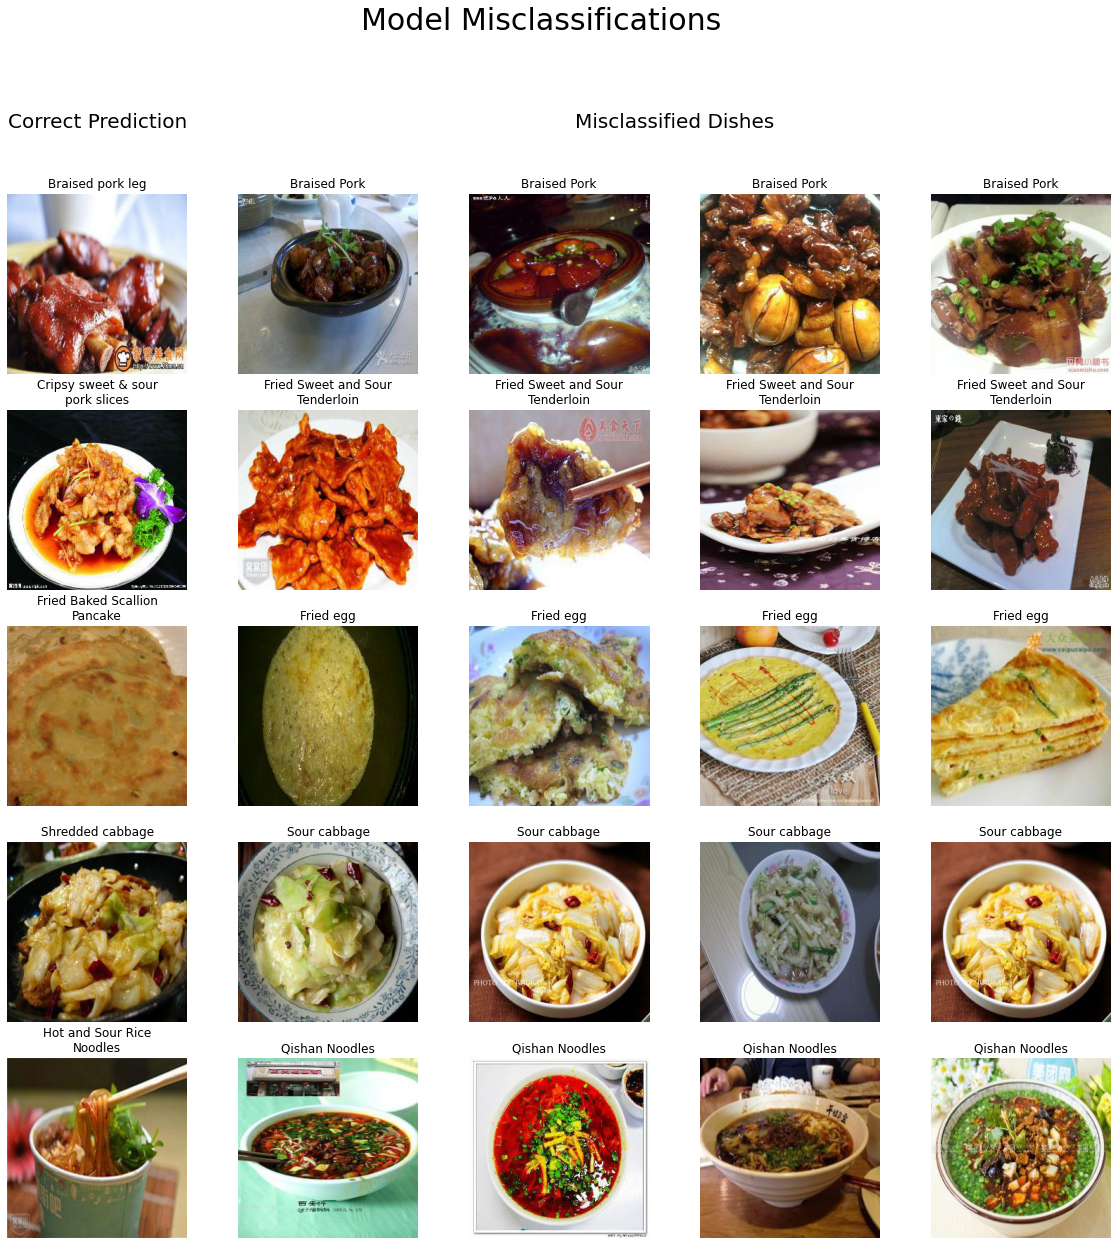

In [71]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20)) 
#set a figure title on top
fig.suptitle("Model Misclassifications", fontsize=30)
# adjust the subplots, i.e. leave more space at the top to accomodate the additional titles
fig.subplots_adjust(top=0.85)     

ext = []
#loop over the columns (j) and rows(i) to populate subplots
for i in range(5):
    for j in range(5):
        title = "\n".join(wrap(titles_to_display[5*i+j], 20))
        axes[i][j].set_title(title)
        axes[i][j].imshow(Image.open(images_to_display[5*i + j]))
        axes[i][j].axis('off')
    ext.append([axes[0,i].get_window_extent().x0, axes[0,i].get_window_extent().width ])

# this is optional
# from the axes bounding boxes calculate the optimal position of the column spanning title
inv = fig.transFigure.inverted()
width_left = ext[0][0]+(ext[0][0]+ext[0][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )
width_right = ext[1][0]+(ext[4][0]+ext[4][1]-ext[1][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0],0.90,"Correct Prediction", va="center", ha="center", size=20)
plt.figtext(right_center[0],0.90,"Misclassified Dishes", va="center", ha="center", size=20)

plt.show()


# https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns